In [25]:
!sudo apt install tesseract-ocr
!export TESSDATA_PREFIX="/usr/share/tesseract-ocr/"
!source ~/.bashrc
!sudo apt-get install tesseract-ocr-kor
!pip install numpy opencv-contrib-python
!pip install pytesseract
!pip install easyocr
!pip install gradio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (22.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [26]:
import easyocr
import pytesseract
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import gradio as gr

In [27]:
# 버전 확인하기
print(f'pytesseract : {pytesseract.__version__}, easyocr : {easyocr.__version__}, gradio : {gr.__version__}')

pytesseract : 0.3.10, easyocr : 1.7.0, gradio : 3.40.1


In [28]:
# easyocr모델 불러와서 이미지를 넣어주는 함수
def read_easyocr(image):
    reader = easyocr.Reader(['ko','en'])
    results = reader.readtext(image)
    return results

In [29]:
# 테서렉트로 이미지 넣어주는 함수
def read_pytesseract(image):
    results = pytesseract.image_to_string(image, lang='kor+eng')
    return results

In [32]:
# 필터 적용해주기
def sepia(input_img):
    sepia_filter = np.array([
        [0.393, 0.769, 0.189],
        [0.349, 0.686, 0.168],
        [0.272, 0.534, 0.131]
    ])
    sepia_img = input_img.dot(sepia_filter.T)
    sepia_img /= sepia_img.max()
    return sepia_img

In [33]:
path = '/content/drive/MyDrive/eadgnus 프로젝트/OCR시험/you.jpg'

In [34]:
os.path.isfile(path)

True

(2048, 1536, 3)
(1898, 1536)
uint8
ROI (x, y, w, h) :  (0, 150, 1700, 2000)


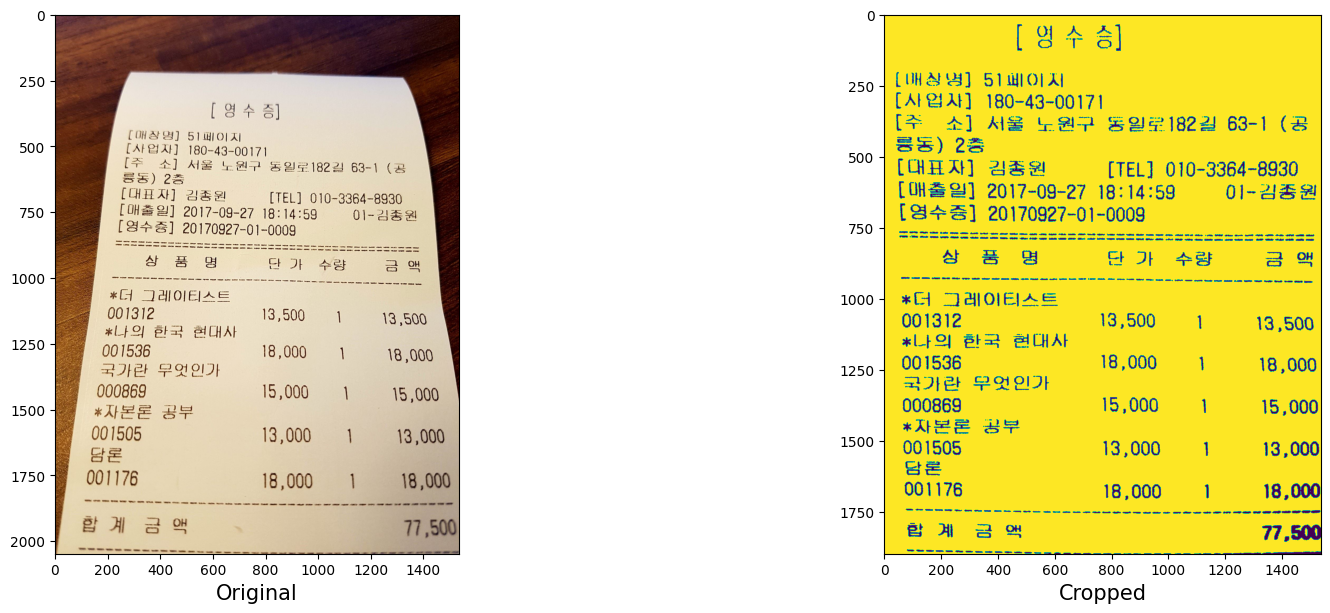

In [35]:
# Image Load (BGR)
image = cv2.imread(path)  # image size (9248, 6936, 3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

plt.figure(figsize = [20, 7])
plt.subplot(1,2,1)
plt.imshow(image)
plt.xlabel("Original", fontsize = 15)

x1, y1 = 287, 213
x2, y2 = 1321, 235
x3, y3 = 7, 2045
x4, y4 = 1535, 2045

# 원래 이미지에서 차지하는 부분 좌표
src_points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

# 결과 이미지에서 원래 이미지 크기 그대로 자르기 위한 좌표
dst_points = np.float32([[0, 0], [1536, 0], [0, 2048], [1536, 2048]])

# 변환 매트릭스
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 이미지 변환
transformed_image = cv2.warpPerspective(image, M, (1536, 2048))

getROI = (0, 150, 1700, 2000) # (x, y, w, h)

# 자르기
cropped_image = transformed_image[getROI[1]:getROI[1]+getROI[3], getROI[0]:getROI[0]+getROI[2]]


# 세피아 필터 적용해서 결과 확인해보기
img = sepia(cropped_image)
# 이미지 정규화
img = cv2.normalize(cropped_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img = img.astype('uint8')

# 이미지 shape 수정
img = np.squeeze(img)

# 필터
# 이미지 이진화
# 미디안 블러를 적용하여 이미지 노이즈 제거
blurred = cv2.medianBlur(cropped_image, 3)

gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
thresh, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(binary.shape)
print(binary.dtype)


plt.subplot(1,2,2)
plt.imshow(binary)
plt.xlabel("Cropped", fontsize = 15)
print("ROI (x, y, w, h) : ", getROI)

In [36]:
# tesseract
text = read_pytesseract(binary)
print(text)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 488, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1431, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.10/dist-packages/gradio/utils.py", line 706, in wrapper
    response = f(*args, **kwargs)
  Fi

[ 영수증]

[배창병] 51페이지

[사업자] 180-43-00171|

[주 소] 서울 노원구 동일로182길 63-1 (공
25) 28

[대표자] 김종원    [TEL] 010-3364-8930
(OHSS 2!) 2017-09-27 18:14:59    01-déez
[영수증] 20170927-01-0009

eee we ee ee
a

스스 아스 아나 TU OA Oe FA HAND OAD CED CO 시 시사 Atm SO OTR RE CORN Ney GO ott ON ey cine Hin UE) ane mat tes GE AED “AS SD om Ome

상 S&S 명     단가 수량    a OF
*너 그레이티스트
001312          13,500   ㅣ    13,500
*lL- 2) etat EIULAT
001536           18 ,000   1    18 ,000
국가란 무엇인가
000869                                15 ,000          ㅣ             15,000
*자본몬 공부
001505           13,000   1    13,000
담론
001176           18,000   ]    18,000



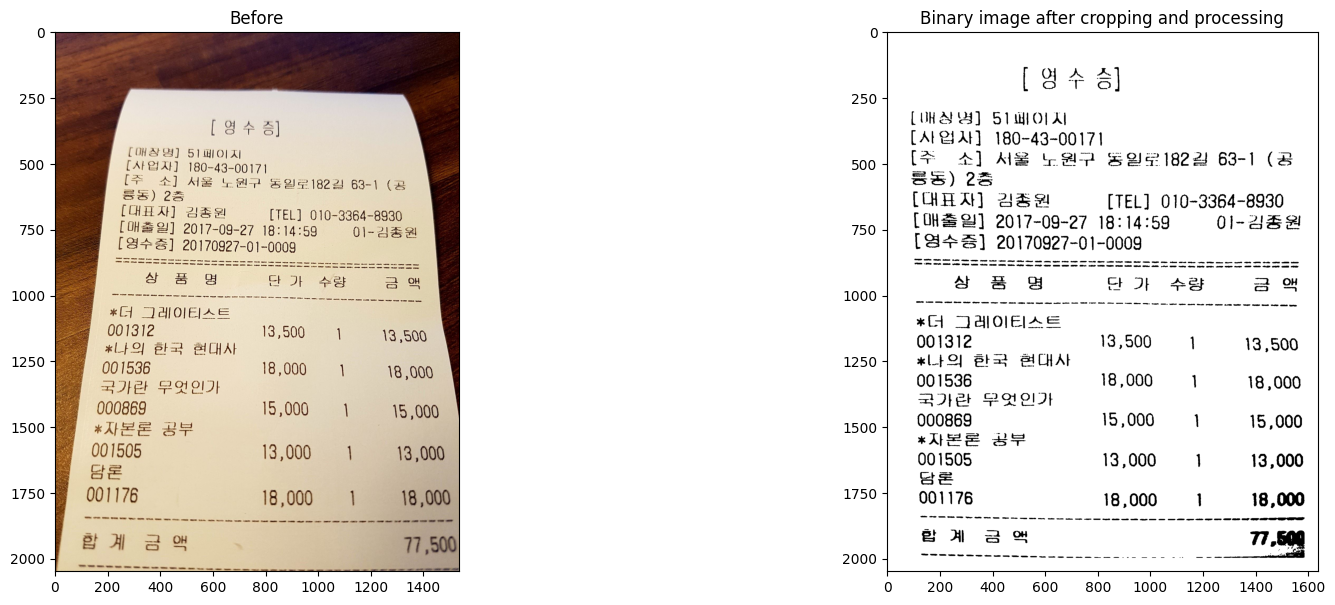

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

LIAS

[내창병] 51페이지
[사업자] 180-43~0017|

[주 소] 서울 노원구 동일로182길 63-1 (공

SS) 25
[대표자] 김종원    [TEL] 010-3364-8930
[OH2 21] 2017-09-27 18:14:59 0|-김종원
[영수증] 20170927-01-0009

상 품 명     단 가 수량 금액
*더 그레이티스트
001312          13,500 1 13,500
*나의 한국 현대사
001536          18,000 1 18,000
국가란 무엇인가
000869              15,000 1 15,000
*자본론 공부
001505              13,000 1 13,000
담론
001176          18.000 1 18,000

[([[502, 118], [898, 118], [898, 238], [502, 238]], '[ 영 수 승]', 0.5879706623642176), ([[80, 292], [364, 292], [364, 364], [80, 364]], '[(손명]', 0.08854335210623504), ([[393, 293], [688, 293], [688, 365], [393, 365]], '51 폐이시', 0.522277716573835), ([[79, 361], [366, 361], [366, 440], [79, 440]], '[사입사]', 0.9765837517961091), ([[401, 367], [828, 367], [828, 444], [401, 444]], '180-43-00171', 0.8633629216220112), ([[83, 441], [189, 441], [189, 509], [83, 509]], '[주', 0.9999892104238298), ([[262, 444], [372, 444], [372, 518], [262, 518]], '소]', 0.9999041594117152), ([[410, 446], [548, 446], [548, 51

In [37]:
image = cv2.imread(path)  # image size (9248, 6936, 3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 여유 공간 추가를 위한 파라미터
top, bottom, left, right = 50,50,50,50


x1, y1 = 287, 213
x2, y2 = 1321, 235
x3, y3 = 7, 2045
x4, y4 = 1535, 2045

# 원래 이미지에서 차지하는 부분 좌표
src_points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

# 결과 이미지에서 원래 이미지 크기 그대로 자르기 위한 좌표
dst_points = np.float32([[0, 0], [1536, 0], [0, 2048], [1536, 2048]])

# 변환 매트릭스 생성
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 이미지 변환
transformed_image = cv2.warpPerspective(image, M, (1536, 2048))

# 노란색을 흰색으로 변경
idx = np.where((transformed_image[:,:,0] > 170) & (transformed_image[:,:,1] > 170) & (transformed_image[:,:,2] < 100))
transformed_image[idx[0], idx[1], :] = [255, 255, 255]


# 이미지 crop
getROI = (0, 100, 2000, 2040) # (x, y, w, h)
img_cropped = transformed_image[getROI[1]:getROI[1]+getROI[3], getROI[0]:getROI[0]+getROI[2]]

# 이미지 이진화
gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)




# 이미지에 여유 공간을 추가
img = cv2.copyMakeBorder(gray, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])




# blurred = cv2.medianBlur(gray, 3)
blur = cv2.GaussianBlur(img, ksize=(3,3),sigmaX=0)

# 미디안 블러
blur = cv2.medianBlur(blur, 3)


# blur[y:y+h, x:x+w] = total_roi

# 합계부분만 블러 x하기위해 영역지정
x, y, w, h = 10, 1700, 2000, 180

#합계부분만 따로 오츠 적용해주기


# 라플라시안 적용 전
thresh, binary = cv2.threshold(blur, 45, 248, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


x, y, w, h = 10, 1850, 2000, 180
total_roi = image[y:y+h, x:x+w]

gray_roi = cv2.cvtColor(total_roi, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # 이미지의 밝기 대비 조절을 위한 CLAHE 객체 생성
gray_roi = clahe.apply(gray_roi) # CLAHE 객체를 이용해 밝기 대비 조절
_, binary_img = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # 이진화
kernel = np.ones((5, 5), np.uint8) # 팽창(dilate) 연산이 적용될 커널 설정
binary_img = cv2.dilate(binary_img, kernel, iterations=3) # 이미지의 이진화된 부분들 팽창 연산
_, label = cv2.connectedComponents(binary_img) # 이어진 영역 추출
uniq, counts = np.unique(label, return_counts=True) # 이어진 영역당 픽셀 수 카운팅
t_max_idx = np.argmax(counts[1:]) # 배경 영역은 뺀 최대값 영역 index 찾기
t_label = uniq[t_max_idx+1] # 이어진 영역들이 0부터 시작하므로 뺀 상태에서의 최대값 영역 구하기
h, w = label.shape[:2]
y, x = np.where(label == t_label) # 해당 영역의 윤곽을 찾아 추출
y_min, x_min = np.min(y), np.min(x)
y_max, x_max = np.max(y), np.max(x)

# 해당 영역에 적용할 마스크 생성
mask = np.zeros((h, w), dtype=np.uint8)
mask[y_min:y_max, x_min:x_max] = 255

# 해당 영역에만 흰색으로 적용한 결과 이미지
yellow_mask = cv2.bitwise_and(total_roi, total_roi, mask=mask)
yellow_mask[mask == 0] = [255, 255, 255]



plt.figure(figsize=[20, 7])

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Before")

plt.subplot(1,2,2)
plt.imshow(binary, cmap='gray')
plt.title("Binary image after cropping and processing")
plt.show()

# tesseract
text = read_pytesseract(binary)
easyocr_text = read_easyocr(binary)
text2 = read_easyocr(yellow_mask)
print(text)
print(easyocr_text)
print(text2)